<a href="https://colab.research.google.com/github/hamednasr/PyTorch/blob/main/FMNIST_classification_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FMNIST fashion dataset classification in PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

## importing and exploring the data

In [2]:
trans = T.Compose([T.ToTensor()])

In [3]:
# device= 'cpu'
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
device

device(type='cuda', index=0)

In [4]:
train = torchvision.datasets.FashionMNIST('FMNIST',train=True,transform=trans,download=True)
train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: FMNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
test = torchvision.datasets.FashionMNIST('FMNIST',train=False,transform=trans,download=True)
test

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: FMNIST
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
test.data.shape

torch.Size([10000, 28, 28])

In [7]:
test.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

In [8]:
batchsize=128
trainloader = DataLoader(train,batch_size=batchsize,shuffle=True,drop_last=True)
testloader = DataLoader(train,batch_size=test.data.shape[0])

In [9]:
torch.randint(0,60000,(1,10))

tensor([[24541, 13953, 52549, 36132, 17171, 43993, 42748, 23423, 47811, 57824]])

In [10]:
train.data[:10].shape

torch.Size([10, 28, 28])

In [11]:
train.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [29]:
train.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [12]:
list(train.class_to_idx)[0]

'T-shirt/top'

In [13]:
train.targets[7]

tensor(2)

In [14]:
list(train.class_to_idx)[train.targets[7]]

'Pullover'

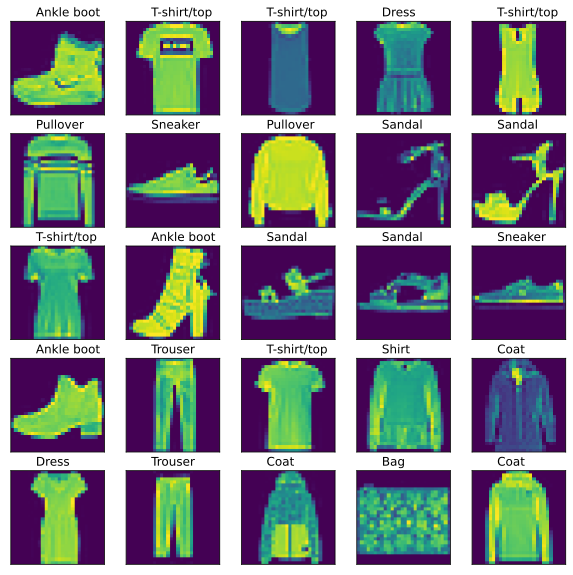

In [15]:
fig , axs = plt.subplots(5,5,figsize=(10,10))
print(enumerate(axs.flatten()))
for  i, ax in enumerate(axs.flatten()):
  ax.imshow(train.data[i,:])
  itemname = list(train.class_to_idx)[train.targets[i]]
  ax.text(7, -2, itemname, fontsize=12)
  ax.set_xticks([])
  ax.set_yticks([]);

## putting data into dataloader and creating model

In [16]:
batchsize=128
trainloader = DataLoader(train,batch_size=batchsize,shuffle=True,drop_last=True)
testloader = DataLoader(test,batch_size=test.data.shape[0])

In [17]:
trainloader.dataset.data.shape

torch.Size([60000, 28, 28])

In [18]:
def CreateModel():
  
  class CNNmodel(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(1,50,kernel_size=3,stride=1,padding=1) #first conv layer
      # (28+2*1-3)/1+1=28   max pool:28/2 = 14
      # self.batchnorm1 = nn.BatchNorm2d(50)
      
      self.conv2 = nn.Conv2d(50,100,kernel_size=3,padding=1) #second conv layer
      #(14+2*1-3)/1+1 = 14  max pool: 14/2 = 7
      # self.batchnorm2 = nn.BatchNorm2d(100)

      self.conv3 = nn.Conv2d(100,200,kernel_size=3,padding=1) #third conv layer
      # # #(7+2*1-3)/1+1 = 7  max pool: 7/2 = 3
      # self.batchnorm3 = nn.BatchNorm2d(200)

      self.fc1 = nn.Linear(3*3*200,400)

      self.fc2 = nn.Linear(400,100)

      self.out = nn.Linear(100,10)

    
    def forward(self,x):

      x = F.max_pool2d(self.conv1(x),2)
      x= F.leaky_relu(x)
      # x = F.dropout(x, p=0.2, training = self.training) 

      x = F.max_pool2d(self.conv2(x),2)
      x= F.leaky_relu(x)
      # x = F.dropout(x, p=0.2, training = self.training) 

      x = F.max_pool2d(self.conv3(x),2)
      x= F.leaky_relu(x)
      # x = F.dropout(x, p=0.2, training = self.training) 

      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))

      x = F.leaky_relu(self.fc1(x))
      # x = F.dropout(x, p=0.5, training = self.training)

      x = F.leaky_relu(self.fc2(x))
      # x = F.dropout(x, p=0.5, training = self.training)
      
      x = self.out(x)      
      
      return x

  CNN = CNNmodel()

  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(params=CNN.parameters(), lr = 0.001)

  return CNN, lossfun, optimizer

## Sanity checking of the model:

In [19]:
X = torch.randn(5,1,28,28)
CNN, lossfun, optimizer = CreateModel()
yhat = CNN(X)
print(yhat.shape)

torch.Size([5, 10])


## Train the Model

In [22]:
epochs = 5

def TrainModel():

  CNN, lossfun, optimizer = CreateModel()
  CNN.to(device)

  trainacc = []
  testacc = []
  trainloss = []
  testloss = []

  for i in range(epochs):
    
    CNN.train()

    batchloss = []
    batchacc = []

    for X, y in trainloader:

      X = X.to(device)
      y = y.to(device)
      
      yhat = CNN(X)

      loss = lossfun(yhat,y)
      batchloss.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step() 

      batchacc.append(100*torch.mean(((torch.argmax(yhat,1)==y).float())).item())

    trainloss.append(np.mean(batchloss))
    trainacc.append(np.mean(batchacc))

    CNN.eval()
    X,y = next(iter(testloader))
    X = X.to(device)
    y = y.to(device)
    yhat = CNN(X)
    testloss.append(lossfun(yhat,y).item())
    testacc.append( 100*torch.mean(((torch.argmax(yhat,1)==y).float())).item() )
    print(f'{i+1} of {epochs} epochs done.')

  return CNN, trainacc, testacc, trainloss, testloss

In [23]:
CNN, trainacc, testacc, trainloss, testloss = TrainModel()

1 of 5 epochs done.
2 of 5 epochs done.
3 of 5 epochs done.
4 of 5 epochs done.
5 of 5 epochs done.


## model evaluation

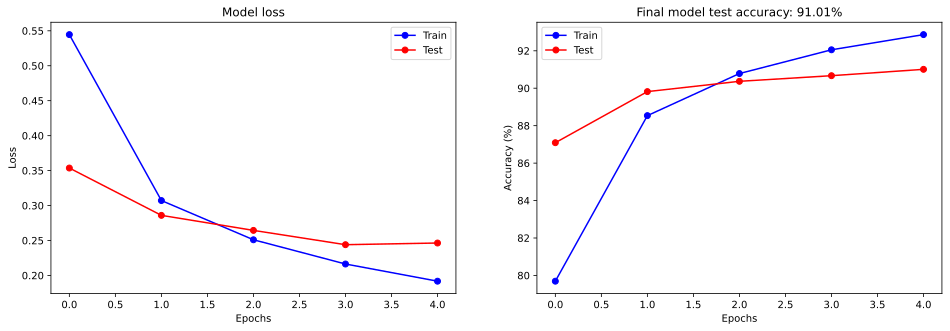

In [24]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainloss,'bo-',label='Train')
ax[0].plot(testloss,'ro-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainacc,'bo-',label='Train')
ax[1].plot(testacc,'ro-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testacc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [25]:
X,y = next(iter(testloader))
print(y)
CNN.cpu()
probs = CNN(X)
yhat = torch.argmax(probs, axis = 1)
print(yhat)

tensor([9, 2, 1,  ..., 8, 1, 5])
tensor([9, 2, 1,  ..., 8, 1, 5])


In [28]:
print('report:\n\n',classification_report(y,yhat))

report:

               precision    recall  f1-score   support

           0       0.85      0.88      0.86      1000
           1       0.98      0.99      0.98      1000
           2       0.88      0.82      0.85      1000
           3       0.87      0.95      0.91      1000
           4       0.82      0.88      0.85      1000
           5       0.98      0.99      0.98      1000
           6       0.80      0.69      0.74      1000
           7       0.97      0.95      0.96      1000
           8       0.99      0.98      0.98      1000
           9       0.96      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



Confusion matrix, without normalization
[[881   3  25  31   4   1  48   0   7   0]
 [  0 989   0  11   0   0   0   0   0   0]
 [ 10   2 821   9 101   0  56   0   1   0]
 [ 12   2  11 947  11   0  17   0   0   0]
 [  0   3  19  49 879   0  48   0   2   0]
 [  0   0   0   0   0 987   0   8   0   5]
 [135   7  57  39  66   1 691   0   4   0]
 [  0   0   0   0   0  16   0 950   0  34]
 [  2   3   0   4   5   2   0   0 984   0]
 [  1   0   0   0   0   5   0  22   0 972]]
Normalized confusion matrix
[[0.88 0.   0.03 0.03 0.   0.   0.05 0.   0.01 0.  ]
 [0.   0.99 0.   0.01 0.   0.   0.   0.   0.   0.  ]
 [0.01 0.   0.82 0.01 0.1  0.   0.06 0.   0.   0.  ]
 [0.01 0.   0.01 0.95 0.01 0.   0.02 0.   0.   0.  ]
 [0.   0.   0.02 0.05 0.88 0.   0.05 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.99 0.   0.01 0.   0.01]
 [0.14 0.01 0.06 0.04 0.07 0.   0.69 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.02 0.   0.95 0.   0.03]
 [0.   0.   0.   0.   0.01 0.   0.   0.   0.98 0.  ]
 [0.   0.   0.   0.   0.

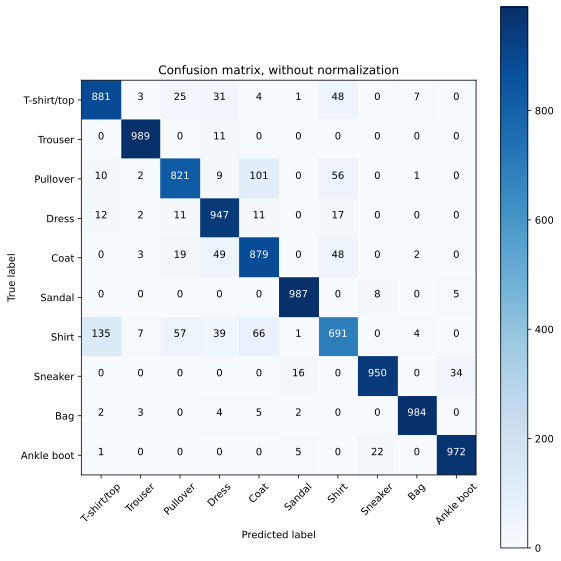

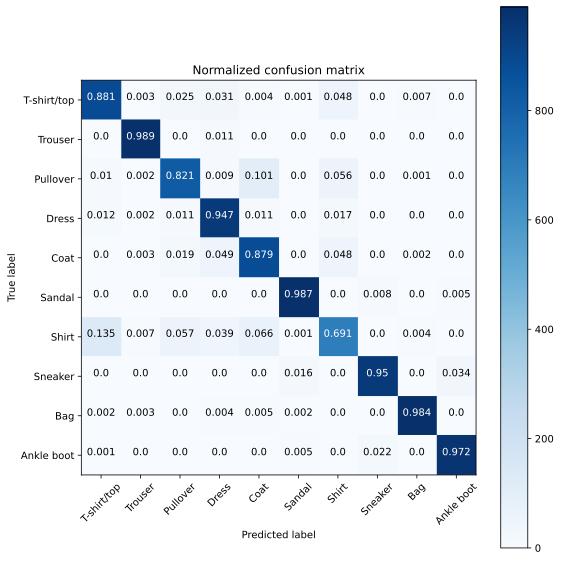

In [33]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
class_names = train.classes
cnf_matrix = confusion_matrix(y, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()